<a href="https://colab.research.google.com/github/hishaam19/RockID/blob/TrainingModelsAlex/Rock_recognition_modelAlex.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import keras
import tensorflow as tf
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
import cv2
import os
from keras import layers
from keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPooling2D,BatchNormalization,GlobalAveragePooling2D,regularization
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras import regularizers
import seaborn as sns
print(tf. __version__)

2.12.0


In [4]:

img_width=224
img_height=224
batch_size=32
num_of_classes=17

TRAIN_DIR= "/content/drive/MyDrive/Datasets/gemstone_roboflow_2/train"
#TEST_DIR= "/content/drive/MyDrive/Datasets/cleaned_dataset/test"
VAL_DIR = "/content/drive/MyDrive/Datasets/gemstone_roboflow_2/valid"

In [5]:
#preprocessing datasets
train_data = ImageDataGenerator(
                                    #rescale=1./255,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=False,

                                    vertical_flip=False  )


val_data = ImageDataGenerator(horizontal_flip=False)
test_data = ImageDataGenerator(horizontal_flip=False)

train_gen = train_data.flow_from_directory(TRAIN_DIR,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                target_size=(img_height, img_width))





val_gen = val_data.flow_from_directory(VAL_DIR,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                target_size=(img_height, img_width)
                                                            )
"""test_gen = test_data.flow_from_directory(TEST_DIR,
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                                shuffle=True,
                                                target_size=(img_height, img_width)
                                                            )"""


Found 4948 images belonging to 85 classes.
Found 282 images belonging to 85 classes.


"test_gen = test_data.flow_from_directory(TEST_DIR,\n                                                batch_size=batch_size,\n                                                class_mode='categorical',\n                                                shuffle=True,\n                                                target_size=(img_height, img_width)\n                                                            )"

In [6]:
model=Sequential()
pretrained_model=tf.keras.applications.EfficientNetB3(include_top=False,
              weights='imagenet',
              input_shape=(img_height,img_width,3),pooling='max',drop_connect_rate=0.4)
for layer in pretrained_model.layers:
  layer.trainable = True


#model.add(Dense(512,bias_regularizer='l1_l2',kernel_regularizer='l1_l2',activity_regularizer='l1_l2',activation='relu'))
model.add(pretrained_model)
#model.add(BatchNormalization())
#model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(0.5))
model.add(Dense(85, activation='softmax'))


model.compile(optimizer=Adam(learning_rate=0.001),
      loss='categorical_crossentropy',
      metrics =['accuracy'])

model.summary()


43941136/43941136 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 dense (Dense)               (None, 1024)              1573888   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 85)                43605     
                                                         

In [7]:
ModelCallbacks = [EarlyStopping(monitor='val_loss', patience=5,  restore_best_weights=True)]
print(train_gen)
history = model.fit(train_gen,epochs=20,verbose=1,validation_data=val_gen)

Epoch 1/20
155/155 [==============================] - 980s 6s/step - loss: 16.5779 - accuracy: 0.0422 - val_loss: 10.3457 - val_accuracy: 0.1064
Epoch 2/20
155/155 [==============================] - 97s 621ms/step - loss: 7.6820 - accuracy: 0.1962 - val_loss: 5.3864 - val_accuracy: 0.2801
Epoch 3/20
155/155 [==============================] - 96s 618ms/step - loss: 4.5805 - accuracy: 0.3438 - val_loss: 3.4738 - val_accuracy: 0.4184
Epoch 4/20
155/155 [==============================] - 96s 617ms/step - loss: 3.3737 - accuracy: 0.4319 - val_loss: 3.1591 - val_accuracy: 0.4291
Epoch 5/20
155/155 [==============================] - 97s 623ms/step - loss: 2.7730 - accuracy: 0.4913 - val_loss: 2.9173 - val_accuracy: 0.4752
Epoch 6/20
155/155 [==============================] - 97s 625ms/step - loss: 2.4747 - accuracy: 0.5333 - val_loss: 2.3563 - val_accuracy: 0.5887
Epoch 7/20
155/155 [==============================] - 97s 624ms/step - loss: 2.2009 - accuracy: 0.5875 - val_loss: 2.4527 - val_ac

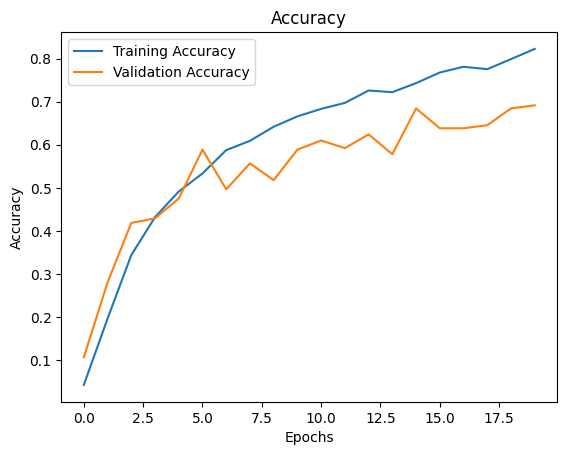

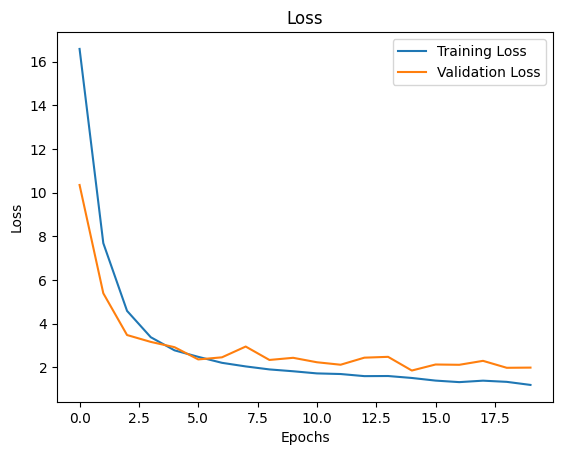

In [8]:


#Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Evaluate test data
9/9 [==============================] - 3s 350ms/step - loss: 1.9817 - accuracy: 0.6915
Test Loss: 1.9817451238632202
Test Accuracy: 0.6914893388748169


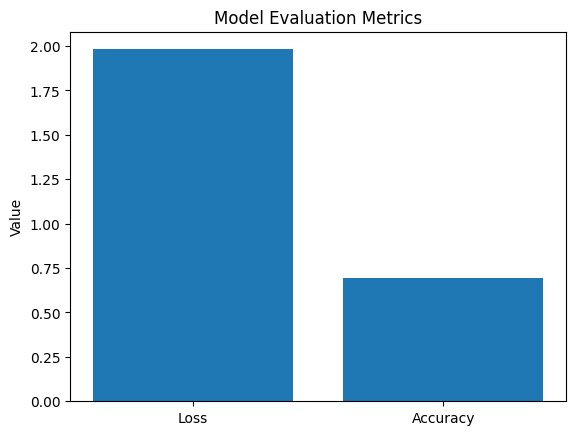

In [15]:
print("Evaluate test data")
#Save model
#tf.keras.saving.save_model("/content/sample_data/")


# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(val_gen)
print('Test Loss:', test_loss)
print('Test Accuracy:', test_accuracy)

# Plot the evaluation metrics
metrics = ['Loss', 'Accuracy']
values = [test_loss, test_accuracy]

plt.bar(metrics, values)
plt.ylabel('Value')
plt.title('Model Evaluation Metrics')
plt.show()

9/9 [==============================] - 4s 141ms/step


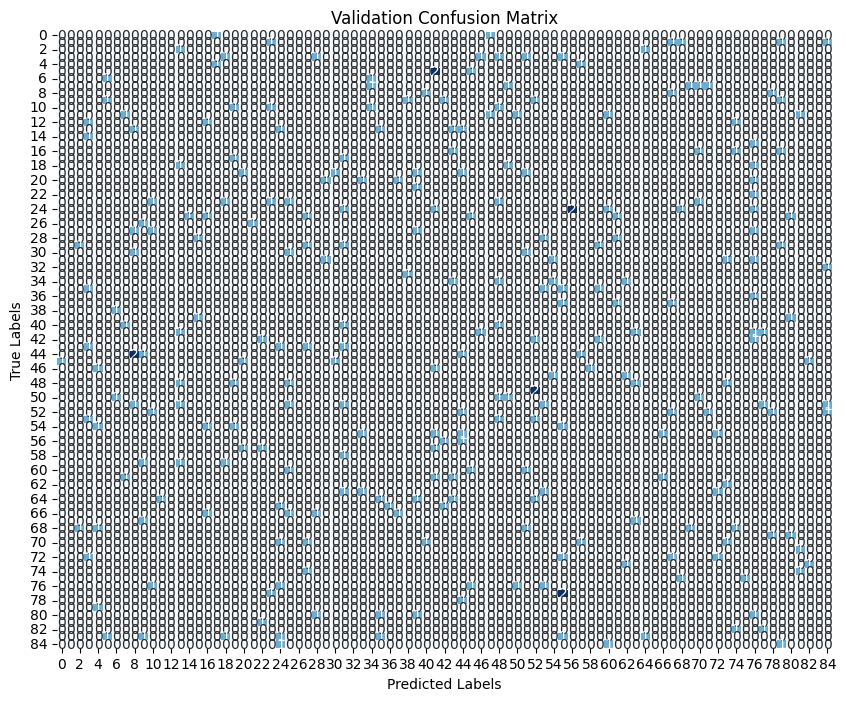

In [20]:
from sklearn.metrics import confusion_matrix

#model.save('test8.h5')
# Compute the confusion matrix
num_classes = val_gen.num_classes
y_train_true = val_gen.classes
y_train_pred_probs = model.predict(val_gen)
y_train_pred_classes = np.argmax(y_train_pred_probs, axis=1)

train_cm = confusion_matrix(y_train_true, y_train_pred_classes)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(train_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Validation Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [28]:

img = tf.keras.preprocessing.image.load_img('/content/drive/MyDrive/Datasets/gemstone_roboflow/train/Alexandrite/alexandrite_0_jpg.rf.5852a7d7665a876b6ef4e106d65dda35.jpg', target_size=(img_width, img_height))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)
#preprocessed_img = preprocess_input(img_array)
predictions = model2.predict(img_array)
print(predictions)

1/1 [==============================] - 0s 57ms/step
[[0.01620205 0.01026553 0.00921987 0.00816036 0.00465904 0.02061319
  0.00808379 0.0052149  0.00814079 0.00280524 0.01486459 0.02199276
  0.01002401 0.01227383 0.01700031 0.81083894 0.01964089]]
